<font size="+3"><strong>Predicting price with size</strong></font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import VimeoVideo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

We have a client who wants to create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400.000 USD

Writing a function named `wrangle` that takes a file path as an argument and returns a DataFrame.
Subset properties of Capital Federal, apartments and price less than 400.000
Remove outliers. Specifically, all observations should fall between the `0.1` and `0.9` quantiles for `"surface_covered_in_m2"`

In [7]:
def wrangle(filepath):
    df = pd.read_excel(filepath)

    # Subset to properties of Capital Federal
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    # Subset to apartments
    mask_apt = df["property_type"] == "apartment"
    # Subset to apartments that cost less than 400.000$
    mask_price = df["price_aprox_usd"] < 400_000

    df = df[mask_ba & mask_apt & mask_price]

    # Remove outliers by surface_area_covered
    low,high = df["surface_covered_in_m2"].quantile([0.1,0.9])
    mask_area = df["surface_covered_in_m2"].between(low,high)

    df = df[mask_area]

    return df

In [9]:
df = wrangle("buenos-aires-real-estate-1.xls")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1.697368e+16,1.842857e+15,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1.812500e+03,2.071429e+15,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2.185185e+15,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1.357143e+15,1.357143e+15,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1.578947e+16,1.800000e+03,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


## Explore

Create a histogram of `"surface_covered_in_m2"`. Make sure that the x-axis has the label `"Area [sq meters]"` and the plot has the title `"Distribution of Apartment Sizes"`.

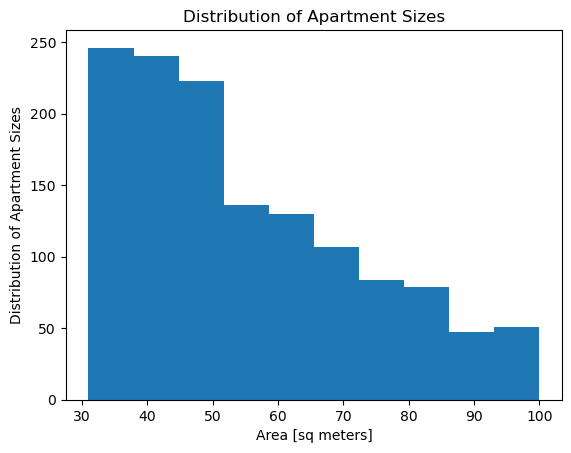

In [11]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Distribution of Apartment Sizes")
plt.title("Distribution of Apartment Sizes");

Calculate the summary statistics for `surface_covered_in_m2` in `df` using the `describe`

In [13]:
df.describe()["surface_covered_in_m2"]

count    1343.000000
mean       55.076694
std        18.160427
min        31.000000
25%        40.000000
50%        50.000000
75%        68.500000
max       100.000000
Name: surface_covered_in_m2, dtype: float64

Create a scatter plot that shows price (`"price_aprox_usd"`) vs area (`"surface_covered_in_m2"`) in dataset. Label x-axis `"Area [sq meters]"` and y-axis `"Price [USD]"`.

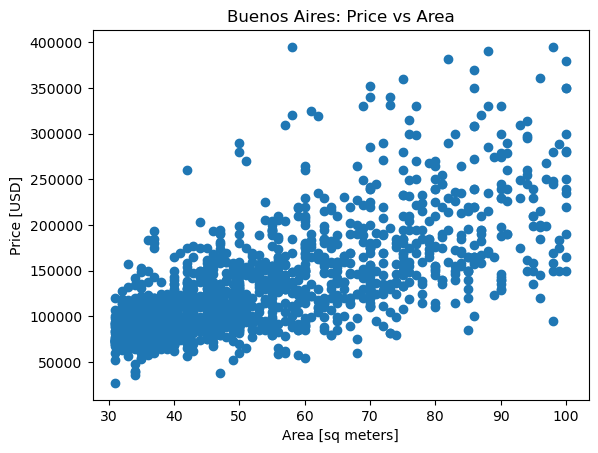

In [15]:
plt.scatter(x=df["surface_covered_in_m2"],y=df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if  thing we want to predict is price, size will be a good feature to include.

## Split

A key part in any model-building project is separating  **target** from  **features**. Since this is my first model, I'll use just one feature: apartment size.

In [16]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.shape

(1343, 1)

Create the target vector named `y_train`, which will be used to train the model. My target should be `"price_aprox_usd"`. In most cases, my target vector should be one-dimensional.


In [17]:
target = "price_aprox_usd"
y_train = df[target]
y_train.shape

(1343,)

# Build Model

## Baseline

In order to know how my `model` is performing, I need to make a "dumb" or "naive" model. This model makes only one prediction.

Calculate the mean of the target vector `y_train` and assign it to the variable `y_mean`.

In [18]:
y_mean = y_train.mean()
y_mean

135527.83871928512

Now that I have the one prediction that my dumb model will always make, I need to generate a list that repeats the prediction for every observation in my dataset.

Create a list named `y_pred_baseline` that contains the value of `y_mean` repeated so that it's the same length at `y`.

In [19]:
y_pred_baseline = [y_mean] * len(y_train)

Add a line to the plot below that shows the relationship between the observations `X_train` and my dumb model's predictions `y_pred_baseline`. The line color should be orange, and it should have the label `"Baseline Model"`.

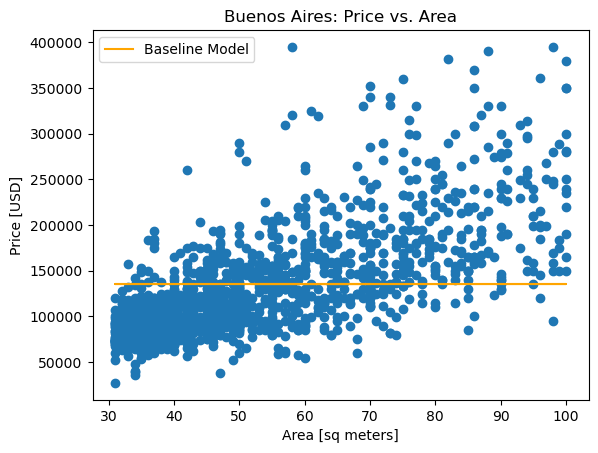

In [20]:
plt.plot(X_train.values,y_pred_baseline,color="orange",label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

it seems like our baseline model doesn't really follow the trend in the data. As a data scientist it's the best practice to use exact, mathematically calculate **performance metric**There are lots of performance metrics, but the one I'll use here is the **mean absolute error**.

In [22]:
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


## Iterate

The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance. Even though the model I'm building is linear, the iteration process rarely follows a straight line.

The first thing to do is create my model — in this case, one that uses linear regression.

Instantiate a [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model named `model`.

In [23]:
model = LinearRegression()

The second thing I need to do is use my data to train our model. Another way to say this is fit my model to the training data.

Fit the model to the data, `X_train` and `y_train`.

In [24]:
model.fit(X_train,y_train)

LinearRegression()

In [25]:
# Check the work
check_is_fitted(model)

## Evaluate

The final step is to evaluate the model. In order to do that, I'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in the training set.

Using the model's [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) method, create a list of predictions for the observations in the feature matrix `X_train`. Name this array `y_pred_training`.

In [26]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

Now that I have predictions, I'll use them to assess my model's performance with the training data. I'll use the same metric I used to evaluate my baseline model: mean absolute error.

Calculate the training mean absolute error for the predictions in `y_pred_training` as compared to the true targets in `y_train`.

In [27]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Good news: The model beat the baseline by over \$10,000! That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that we call the **test set**.
Here I'll use the **test set** that's pre-made

In [29]:
X_test = pd.read_excel("buenos-aires-test-features.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

# Communicate Results

Once my model is built and tested, it's time to share it with others. Presenting simple linear model to a technical audience, they might appreciate an equation. When I created my baseline model, I represented it as a line. The equation for a line like this is usually written as:

<center><img src="Equation.png" alt="Equation: y = beta 0 + beta 1 * x" style="width: 400px;"/></center>

I need to find the values that my model has determined for the intercept and and coefficient. Fortunately, all trained models in scikit-learn store this information in the model itself.

Extract the intercept from the model, and assign it to the variable `intercept`.

In [30]:
intercept = round(model.intercept_,2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.31


Next comes the coefficient. I'll extract it in a very similar way.

Extract the intercept from the model, and assign it to the variable `intercept`.

In [31]:
intercept = round(model.intercept_,2)
print("Model Intercept:", intercept)
assert any([isinstance(intercept, int), isinstance(intercept, float)])

Model Intercept: 11433.31


Extract the coefficient associated `"surface_covered_in_m2"` in the model, and assign it to the variable `coefficient`.

In [32]:
coefficient = round(model.coef_[0],2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)
assert any([isinstance(coefficient, int), isinstance(coefficient, float)])

Model coefficient for "surface_covered_in_m2": 2253.12


Now that I have my `intercept` and `coefficient`, I need to insert them into a string that I can print out the complete equation.

In [33]:
print(f"apr_price = {intercept} + {coefficient} * surface_covered")

apr_price = 11433.31 + 2253.12 * surface_covered


Add a line to the plot below that shows the relationship between the observations in `X_train` and the model's predictions `y_pred_training`. Line color should be red, and that it should have the label `"Linear Model"`.

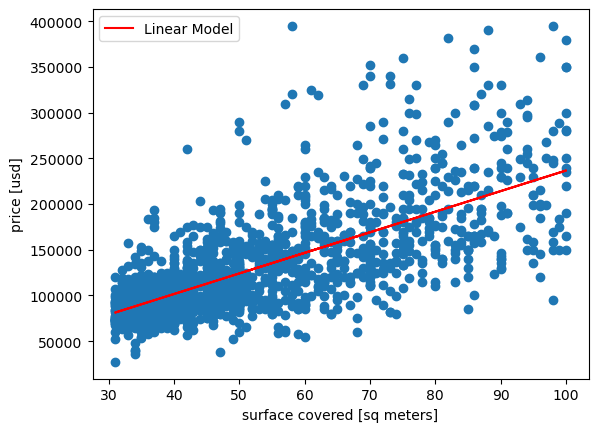

In [34]:
plt.plot(X_train, model.predict(X_train), color="r", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.legend();